In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import torch.nn.init as I

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import nibabel

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
path = "../data_orig/100307/mri/"

In [4]:
img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(path+"T1.mgz")
image = img_orig.get_data().astype(np.float64)
aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(path+"aparc+aseg.mgz")
aseg_img = aseg_img.get_data().astype(np.float64)

In [5]:
aseg_img.shape

(256, 256, 256)

In [6]:
uni = list(np.unique(aseg_img).astype(int))

In [3]:
# uni

In [4]:
available_segments = [0,2,4,5,7,8,10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28, 30, 31, 41,
 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60, 62, 63, 77, 80, 85, 251, 252, 253,
 254, 255, 1000, 1001, 1002, 1003, 1005, 1006, 1007, 1008, 1009, 1010, 1011,
 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024,
 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 2000, 2001,
 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028,
 2029, 2030, 2031, 2032, 2033, 2034, 2035]

In [5]:
rest_available = [2,4,5,7,8,10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28, 30, 31, 41,
 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60, 62, 63, 77, 80, 85, 251, 252, 253,
 254, 255, 1000, 1001, 1002, 1003, 1005, 1006, 1007, 1008, 1009, 1010, 1011,
 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024,
 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 2000, 2001,
 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028,
 2029, 2030, 2031, 2032, 2033, 2034, 2035]

In [6]:
# np.array(uni)==np.array(available_segment)

In [7]:
num_seg = len(rest_available)+1

In [8]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True, \
                 coord = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data
        self.coord = coord

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = self.image_dir[idx]
        aseg_path = self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-10,10)
        dx = np.round(random.uniform(-20,20))
        dy = np.round(random.uniform(-20,20))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
#        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        im = np.array(im, np.float64, copy=False)
        min_im = np.min(im)
        max_im = np.max(im)
        im = (im - min_im)/(max_im - min_im + 1e-4)
#         print(np.sum(im))
        if self.coord:
            im = np.array([im, x_coordinate, y_coordinate], np.float64, copy=False)
            im = torch.from_numpy(im).type(torch.FloatTensor)
        else:
            im = torch.from_numpy(im).type(torch.FloatTensor).unsqueeze(0)

        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((len(rest_available)+1,256,256))
        for i,a in enumerate(available_segments):
            temp = (target==a).astype(int)
            if a in rest_available:
                target_label[rest_available.index(a),:,:] = temp
            else:
                target_label[len(rest_available),:,:] = target_label[len(rest_available),:,:] + temp
        target_label[len(rest_available),:,:] = (target_label[len(rest_available),:,:]>=1).astype(int) 
#        print(target_label.shape)
        target_label = torch.from_numpy(target_label).type(torch.FloatTensor)
        sample = {'x':im,'y':target_label} 
        return sample

In [9]:
file_names = pd.read_csv("complete_path_aparc.csv")
# file_names = file_names.replace(to_replace=".*//.*",value="/")

In [10]:
train_subjects = unpickling("train_sub_index_aparc")
val_subjects = unpickling("val_sub_index_aparc")
test_subjects = unpickling("test_sub_index_aparc")

In [13]:
file_names['left_to_right_raw'][1].split('/')[8]

'126628'

In [14]:
train_subjects[1]

'307127'

In [15]:
len(list(set(train_subjects)))+len(list(set(val_subjects)))+len(list(set(test_subjects)))

1113

In [16]:
file_names.shape

(284928, 6)

In [17]:
1113*256

284928

In [18]:
# train_sub_index = []
# val_sub_index = []
# test_sub_index = []
# for i in range(len(file_names)):
#     name = file_names['left_to_right_raw'][i].split('/')[8]
#     if name in train_subjects:
#         train_sub_index.append(i)
#     elif name in val_subjects:
#         val_sub_index.append(i)
#     elif name in test_subjects:
#         test_sub_index.append(i)


In [11]:
# pickling(train_sub_index,"train_sub_index_aparc")
# pickling(val_sub_index,"val_sub_index_aparc")
# pickling(test_sub_index,"test_sub_index_aparc")

In [12]:
file_names.head()

,left_to_right_raw,left_to_right_segmented,top_to_bottom_raw,top_to_bottom_segmented,back_to_front_raw,back_to_front_segmented
0,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/le...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/le...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/to...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/to...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/ba...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/ba...
1,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/le...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/le...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/to...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/to...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/ba...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/ba...
2,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/le...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/le...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/to...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/to...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/ba...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/ba...
3,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/le...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/le...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/to...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/to...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/ba...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/ba...
4,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/le...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/le...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/to...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/to...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/ba...,/gpfs/data/cbi/hcp/hcp_seg/aparc_all_slices/ba...


In [11]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [12]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:4986]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:1000]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [13]:
cd = False
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False, coord = cd),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2], coord = cd),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3], coord = cd)
                                               }
bs = 8
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [14]:
data = next(iter(dataloader['train']))

In [15]:
data['x'].size(),data['y'].size()

(torch.Size([8, 1, 256, 256]), torch.Size([8, 113, 256, 256]))

In [35]:
# list_arr = []
# for data in dataloader["train"]:
#     y = data['y'].numpy()
#     N,C,_,_ = y.shape
#     sum_arr = np.sum(y.reshape(N,C,-1),axis = 2)
#     list_arr.append(sum_arr)
# final_arr = np.concatenate(list_arr,axis = 0)
# freq_class = np.true_divide(final_arr.sum(0),(final_arr!=0).sum(0)*(256*256))
# class_wts = np.median(freq_class)/freq_class
# pickling(class_wts,'new_class_wts_113_seg')

In [16]:
class_wts = unpickling('new_class_wts_113_seg')

In [17]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [18]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [19]:
class Unet(nn.Module):
    def __init__(self,in_chan = 3, out_chan = 3):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(in_chan,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,out_chan, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        I.xavier_normal(m.weight.data)

In [21]:
wts_torch = Variable(torch.from_numpy(class_wts)).cuda()

In [28]:
def dice_loss_2(true,scores,mean, flag="dice", epsilon = 1e-4,p = 2,we = 0.05):    
    N, C, sh1, sh2 = true.size()
    preds = F.softmax(scores, dim = 1)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
    wts[:,:] = mean[None].repeat(N,1)
    grad_wts = torch.max(mean)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    cel = -torch.sum(wts * torch.sum(true*torch.log(preds),dim = 2),dim = 1)
#     return 40*torch.mean(loss)+we*torch.mean(cel)
    return torch.mean(loss)

In [23]:
def dice_score(true,scores, epsilon = 1e-7):
    N, C, sh1, sh2 = true.size()    
    true = true.view(N,C,-1)
    preds = F.softmax(scores, dim = 1)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*C
    for i in range(C):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*C
    for i in range(C):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
    return dice_class_score

In [29]:
import time
def train_model(model, optimizer,dataloader, name,num_seg = 3, num_epochs = 100, verbose = False, every = 1,\
                print_all_ds = True):
    since = time.time()
    best_loss = np.inf
    best_score = 0
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(num_seg)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*num_seg
            running_total = 0
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).cuda()
                y = Variable(y).cuda()
                N, C, sh1, sh2 = y.size()
                rand_num = np.random.rand()
                if rand_num < 0.90:
                    y_mask = (torch.sum(y[:,:(C-1),:,:].contiguous().view(N,-1),dim = 1) != 0)
                    y = y[y_mask]
                    x = x[y_mask]
                try:
                    output = model(x)
                except:
                    continue
                loss = dice_loss_2(y, output,wts_torch)
                if loss==-1:
                    continue
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * N
                running_total += N
                dice_score_batch = dice_score(y,output)

                for j in range(num_seg):
                    run_class_scores[j] += dice_score_batch[j] * N
            epoch_loss = running_loss/running_total
            loss_hist[phase].append(epoch_loss.item())
            epoch_score = 0
            for j in range(num_seg):
                score = run_class_scores[j]/running_total
                dice_scores_of_all_class[j][phase].append(score.item())
                if j < num_seg - 1:
                    epoch_score += score.item()
            epoch_score_av = epoch_score/ (num_seg - 1)
            if verbose or i%every == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}, Av. Dice Score: {:.4f}'\
                      .format(i,phase,epoch_loss,epoch_score_av))
                if print_all_ds:
                    for j in range(num_seg - 1):
                        print('Class {} (DS): {:.4f}'.format(j,dice_scores_of_all_class[j][phase][-1]))
                print('-'*10)
            
        if phase == 'validate' and epoch_score_av > best_score:
            best_loss = epoch_loss
            best_score = epoch_score_av
            best_model_wts = model.state_dict()
            torch.save(model,name)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}, Best Average DS: {:4f}'.format(best_loss,best_score))
    
    model.load_state_dict(best_model_wts)
    pickling(loss_hist,name+'loss_hist')
    pickling(dice_scores_of_all_class,name+'dice_hist')
    
    return model, loss_hist, dice_scores_of_all_class

In [25]:
model = Unet(in_chan = 1,out_chan = num_seg).cuda()
model.apply(weights_init)
model = nn.DataParallel(model)
criterion = dice_loss_2

In [30]:
optimizer = optim.Adam(model.parameters(),lr = 1e-5)

In [31]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'aparc_model1_1e-4_1',num_seg = num_seg, num_epochs = 10,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 0.1736, Av. Dice Score: 0.9253
Class 0 (DS): 0.9168
Class 1 (DS): 0.9631
Class 2 (DS): 0.9359
Class 3 (DS): 0.9039
Class 4 (DS): 0.9301
Class 5 (DS): 0.9538
Class 6 (DS): 0.9646
Class 7 (DS): 0.9625
Class 8 (DS): 0.9439
Class 9 (DS): 0.9613
Class 10 (DS): 0.9222
Class 11 (DS): 0.9354
Class 12 (DS): 0.9563
Class 13 (DS): 0.9700
Class 14 (DS): 0.9429
Class 15 (DS): 0.9598
Class 16 (DS): 0.9495
Class 17 (DS): 0.9836
Class 18 (DS): 0.8453
Class 19 (DS): 0.9191
Class 20 (DS): 0.9648
Class 21 (DS): 0.9642
Class 22 (DS): 0.9073
Class 23 (DS): 0.9236
Class 24 (DS): 0.9624
Class 25 (DS): 0.9569
Class 26 (DS): 0.9684
Class 27 (DS): 0.9587
Class 28 (DS): 0.9526
Class 29 (DS): 0.9714
Class 30 (DS): 0.9631
Class 31 (DS): 0.9578
Class 32 (DS): 0.9851
Class 33 (DS): 0.8414
Class 34 (DS): 0.8377
Class 35 (DS): 0.9634
Class 36 (DS): 0.9735
Class 37 (DS): 0.9739
Class 38 (DS): 0.9657
Class 39 (DS): 0.9347
Class 40 (DS): 0.9560
Class 41 (DS): 0.9543
Class 42 (DS): 0.67

Epoch: 2, Phase: train, epoch loss: 0.1506, Av. Dice Score: 0.9290
Class 0 (DS): 0.9300
Class 1 (DS): 0.9636
Class 2 (DS): 0.9443
Class 3 (DS): 0.9090
Class 4 (DS): 0.9302
Class 5 (DS): 0.9532
Class 6 (DS): 0.9670
Class 7 (DS): 0.9631
Class 8 (DS): 0.9453
Class 9 (DS): 0.9653
Class 10 (DS): 0.9300
Class 11 (DS): 0.9413
Class 12 (DS): 0.9628
Class 13 (DS): 0.9720
Class 14 (DS): 0.9568
Class 15 (DS): 0.9633
Class 16 (DS): 0.9531
Class 17 (DS): 0.9837
Class 18 (DS): 0.8541
Class 19 (DS): 0.9295
Class 20 (DS): 0.9652
Class 21 (DS): 0.9672
Class 22 (DS): 0.9107
Class 23 (DS): 0.9271
Class 24 (DS): 0.9665
Class 25 (DS): 0.9583
Class 26 (DS): 0.9692
Class 27 (DS): 0.9612
Class 28 (DS): 0.9569
Class 29 (DS): 0.9724
Class 30 (DS): 0.9656
Class 31 (DS): 0.9624
Class 32 (DS): 0.9859
Class 33 (DS): 0.8489
Class 34 (DS): 0.8387
Class 35 (DS): 0.9654
Class 36 (DS): 0.9765
Class 37 (DS): 0.9750
Class 38 (DS): 0.9660
Class 39 (DS): 0.9490
Class 40 (DS): 0.9560
Class 41 (DS): 0.9581
Class 42 (DS): 0.66

Epoch: 4, Phase: train, epoch loss: 0.1413, Av. Dice Score: 0.9304
Class 0 (DS): 0.9316
Class 1 (DS): 0.9645
Class 2 (DS): 0.9472
Class 3 (DS): 0.9088
Class 4 (DS): 0.9296
Class 5 (DS): 0.9555
Class 6 (DS): 0.9656
Class 7 (DS): 0.9638
Class 8 (DS): 0.9451
Class 9 (DS): 0.9683
Class 10 (DS): 0.9266
Class 11 (DS): 0.9455
Class 12 (DS): 0.9607
Class 13 (DS): 0.9708
Class 14 (DS): 0.9583
Class 15 (DS): 0.9632
Class 16 (DS): 0.9525
Class 17 (DS): 0.9841
Class 18 (DS): 0.8519
Class 19 (DS): 0.9319
Class 20 (DS): 0.9617
Class 21 (DS): 0.9682
Class 22 (DS): 0.9093
Class 23 (DS): 0.9295
Class 24 (DS): 0.9691
Class 25 (DS): 0.9577
Class 26 (DS): 0.9696
Class 27 (DS): 0.9603
Class 28 (DS): 0.9572
Class 29 (DS): 0.9707
Class 30 (DS): 0.9661
Class 31 (DS): 0.9615
Class 32 (DS): 0.9847
Class 33 (DS): 0.8496
Class 34 (DS): 0.8431
Class 35 (DS): 0.9638
Class 36 (DS): 0.9767
Class 37 (DS): 0.9768
Class 38 (DS): 0.9674
Class 39 (DS): 0.9547
Class 40 (DS): 0.9608
Class 41 (DS): 0.9617
Class 42 (DS): 0.66

Epoch: 6, Phase: train, epoch loss: 0.1353, Av. Dice Score: 0.9317
Class 0 (DS): 0.9302
Class 1 (DS): 0.9661
Class 2 (DS): 0.9530
Class 3 (DS): 0.9069
Class 4 (DS): 0.9332
Class 5 (DS): 0.9543
Class 6 (DS): 0.9662
Class 7 (DS): 0.9633
Class 8 (DS): 0.9444
Class 9 (DS): 0.9679
Class 10 (DS): 0.9281
Class 11 (DS): 0.9428
Class 12 (DS): 0.9605
Class 13 (DS): 0.9730
Class 14 (DS): 0.9596
Class 15 (DS): 0.9643
Class 16 (DS): 0.9543
Class 17 (DS): 0.9832
Class 18 (DS): 0.8627
Class 19 (DS): 0.9319
Class 20 (DS): 0.9638
Class 21 (DS): 0.9696
Class 22 (DS): 0.9142
Class 23 (DS): 0.9310
Class 24 (DS): 0.9668
Class 25 (DS): 0.9586
Class 26 (DS): 0.9691
Class 27 (DS): 0.9620
Class 28 (DS): 0.9595
Class 29 (DS): 0.9710
Class 30 (DS): 0.9664
Class 31 (DS): 0.9636
Class 32 (DS): 0.9858
Class 33 (DS): 0.8546
Class 34 (DS): 0.8440
Class 35 (DS): 0.9616
Class 36 (DS): 0.9806
Class 37 (DS): 0.9769
Class 38 (DS): 0.9675
Class 39 (DS): 0.9539
Class 40 (DS): 0.9586
Class 41 (DS): 0.9646
Class 42 (DS): 0.66

Epoch: 8, Phase: validate, epoch loss: 0.1436, Av. Dice Score: 0.9262
Class 0 (DS): 0.9432
Class 1 (DS): 0.9560
Class 2 (DS): 0.9445
Class 3 (DS): 0.9064
Class 4 (DS): 0.9269
Class 5 (DS): 0.9562
Class 6 (DS): 0.9554
Class 7 (DS): 0.9678
Class 8 (DS): 0.9327
Class 9 (DS): 0.9720
Class 10 (DS): 0.9268
Class 11 (DS): 0.9392
Class 12 (DS): 0.9577
Class 13 (DS): 0.9729
Class 14 (DS): 0.9696
Class 15 (DS): 0.9583
Class 16 (DS): 0.9614
Class 17 (DS): 0.9815
Class 18 (DS): 0.8644
Class 19 (DS): 0.9505
Class 20 (DS): 0.9557
Class 21 (DS): 0.9700
Class 22 (DS): 0.8999
Class 23 (DS): 0.9205
Class 24 (DS): 0.9647
Class 25 (DS): 0.9480
Class 26 (DS): 0.9654
Class 27 (DS): 0.9605
Class 28 (DS): 0.9563
Class 29 (DS): 0.9704
Class 30 (DS): 0.9626
Class 31 (DS): 0.9590
Class 32 (DS): 0.9758
Class 33 (DS): 0.8645
Class 34 (DS): 0.8503
Class 35 (DS): 0.9683
Class 36 (DS): 0.9681
Class 37 (DS): 0.9802
Class 38 (DS): 0.9559
Class 39 (DS): 0.9490
Class 40 (DS): 0.9391
Class 41 (DS): 0.9650
Class 42 (DS): 0

In [39]:
def visualize1(image):
    p = F.softmax(image)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(num_seg):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    #plt.title(title)
    #plt.imshow(masked[:,:].cpu().numpy())
    #print(torch.stack(img).size())
    return torch.stack(img).resize(num_seg,1,256,256).cpu()

In [41]:
%matplotlib inline
def show(img):
    
    npimg = img.numpy()
    #print(npimg.shape)
    plt.figure(figsize = (30,30))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

----------------------------------------------------------------------------------------------------
Ground Truth


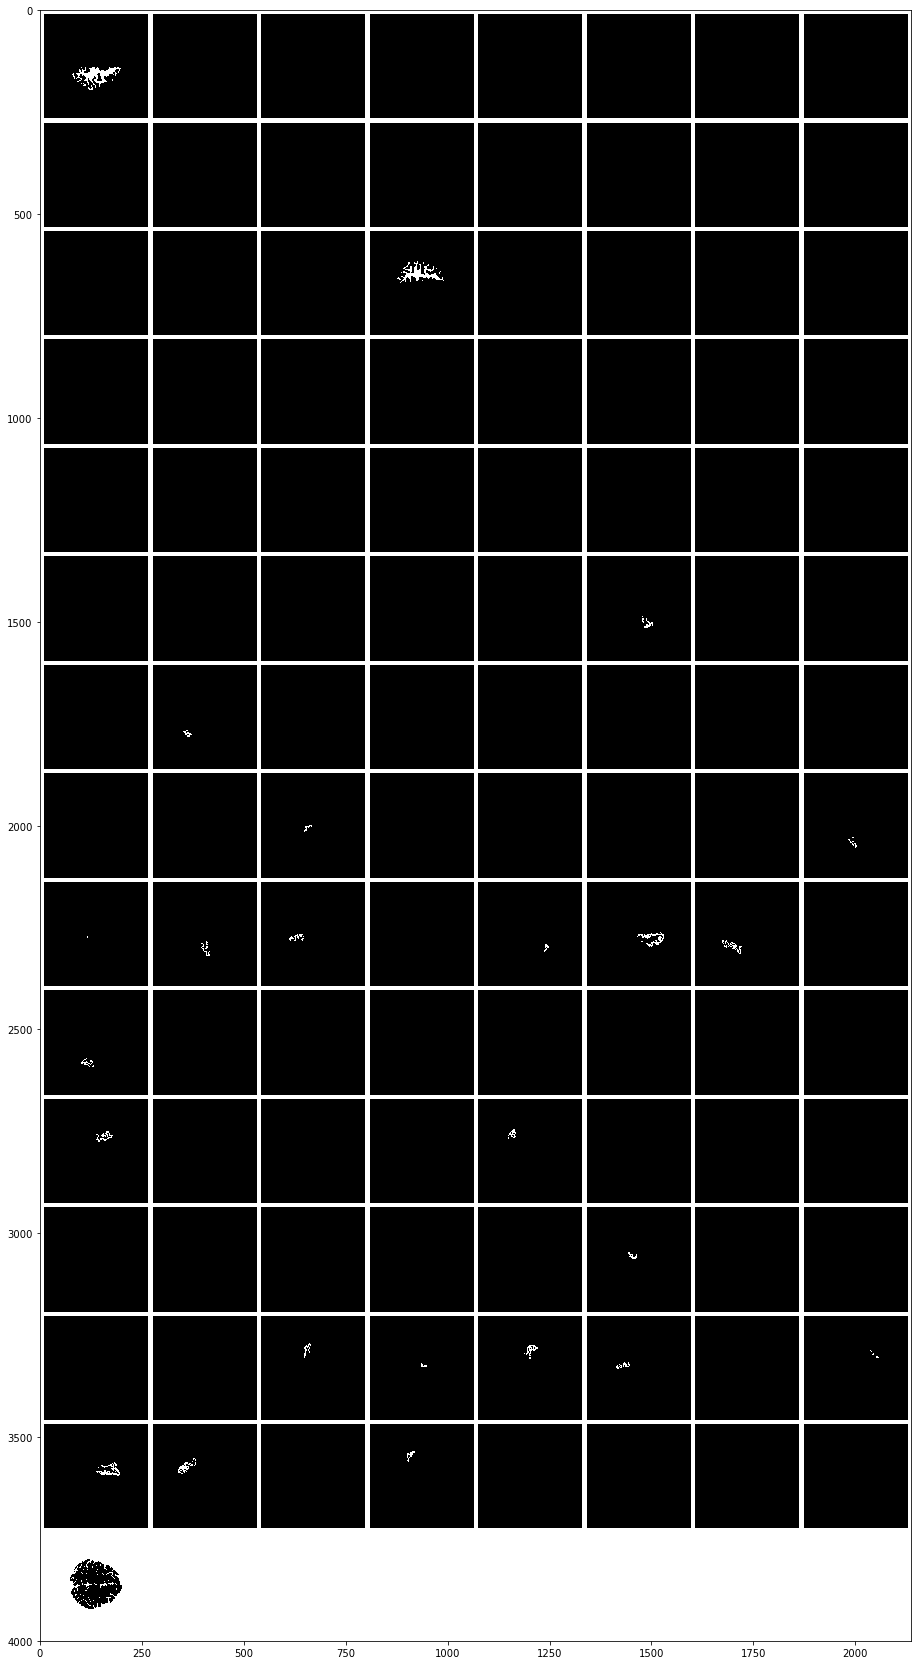

----------------------------------------------------------------------------------------------------
Prediction


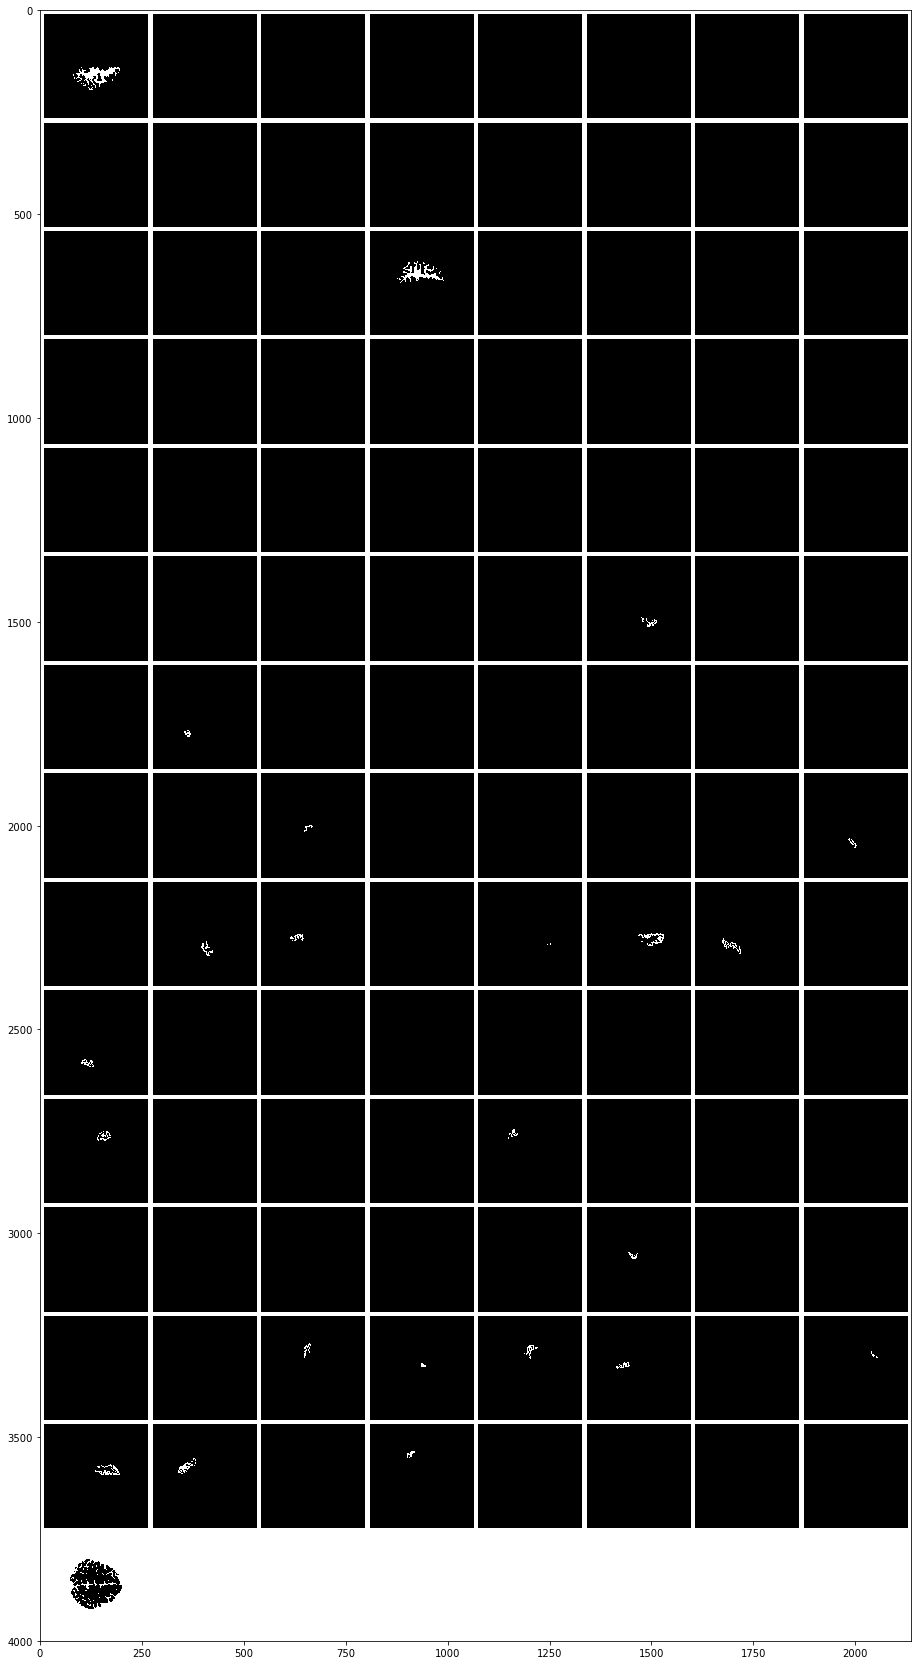

----------------------------------------------------------------------------------------------------
Ground Truth


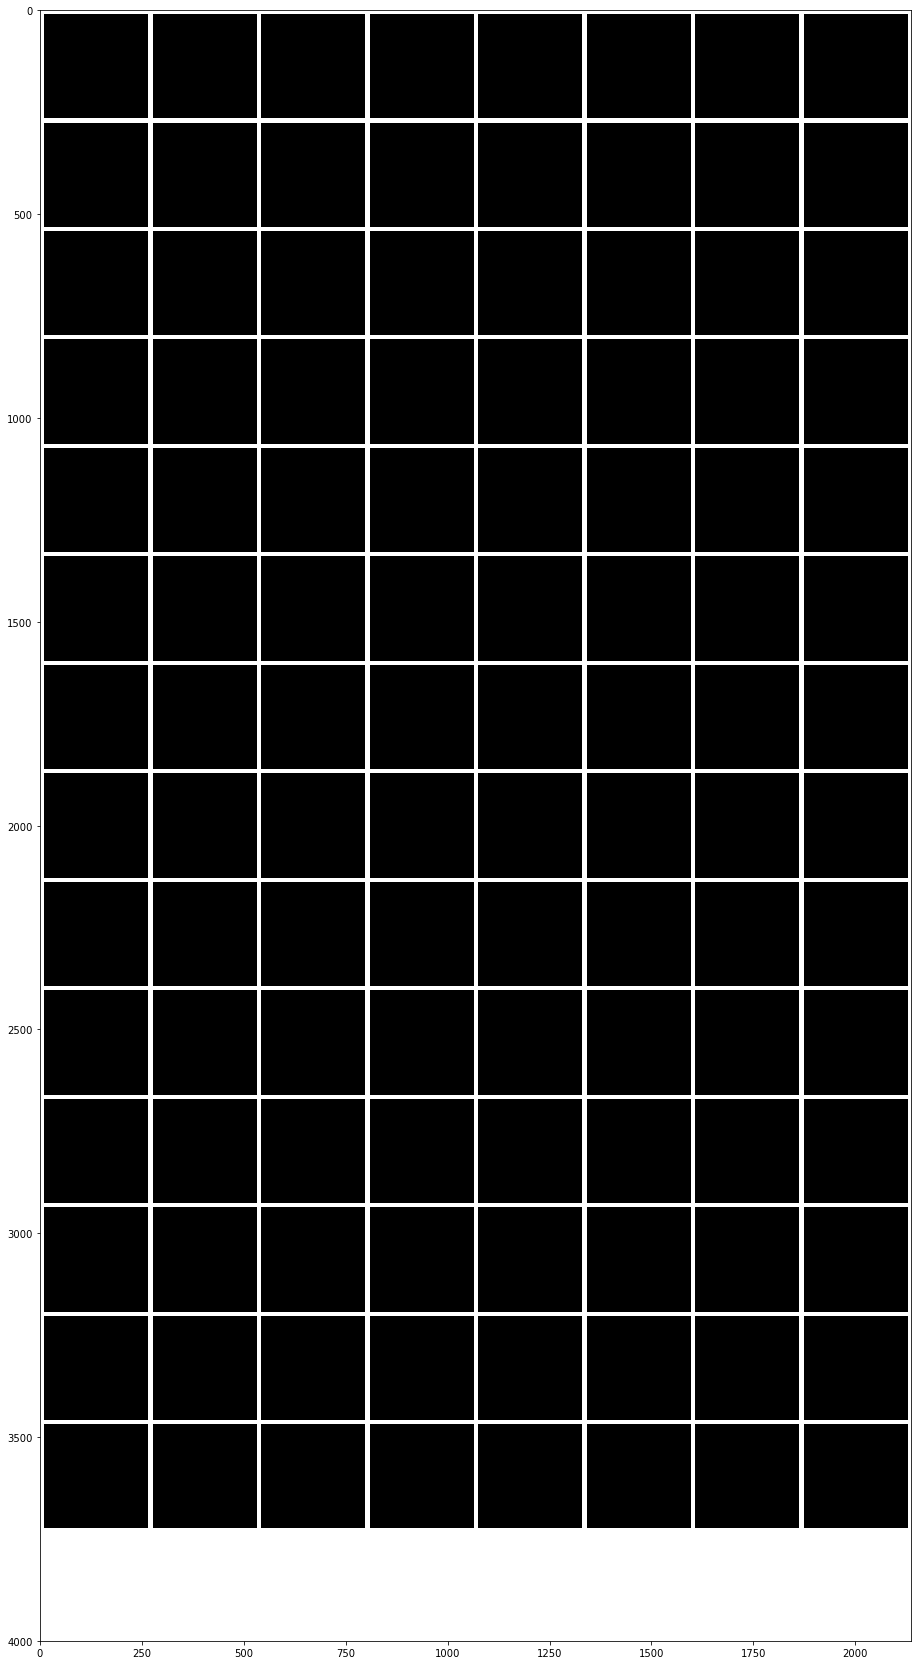

----------------------------------------------------------------------------------------------------
Prediction


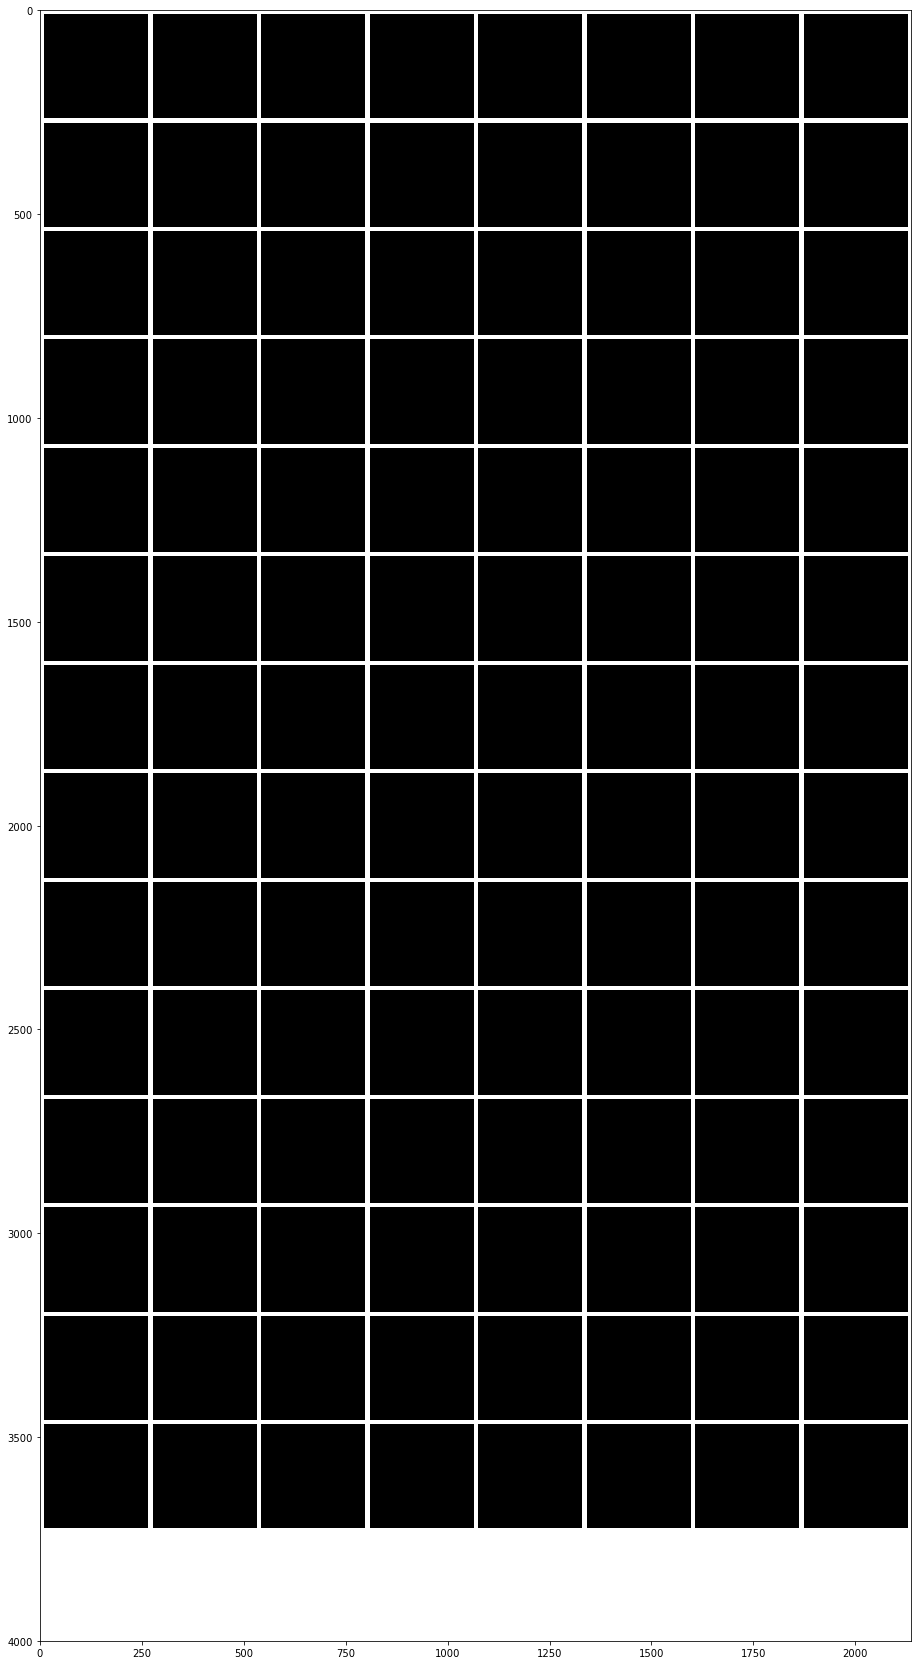

----------------------------------------------------------------------------------------------------
Ground Truth


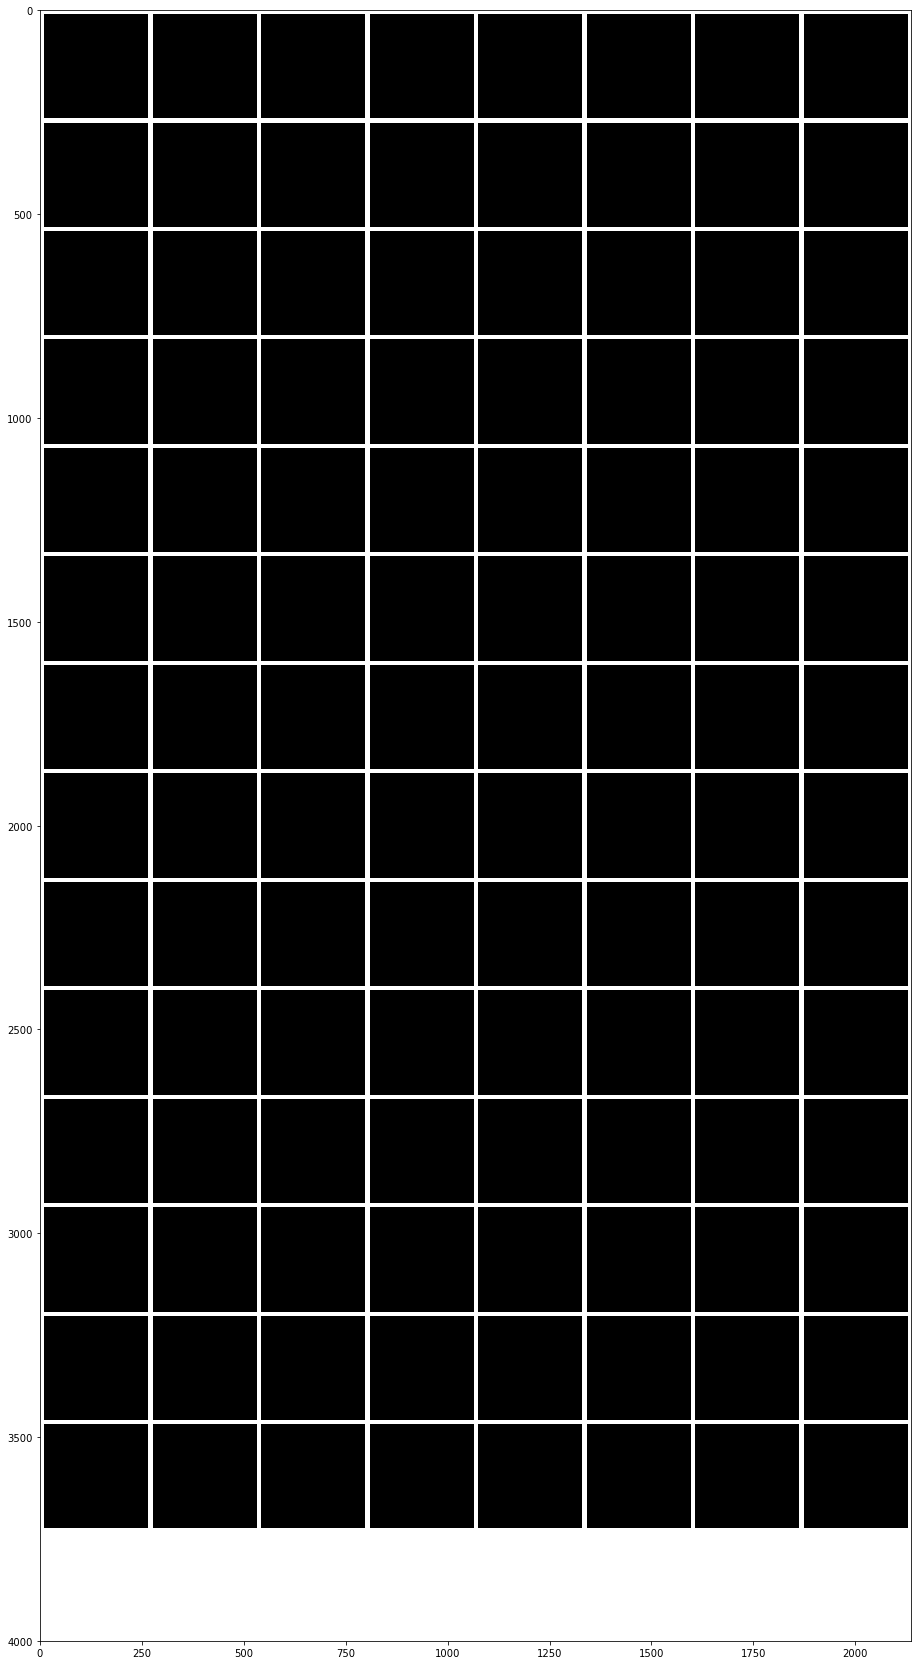

----------------------------------------------------------------------------------------------------
Prediction


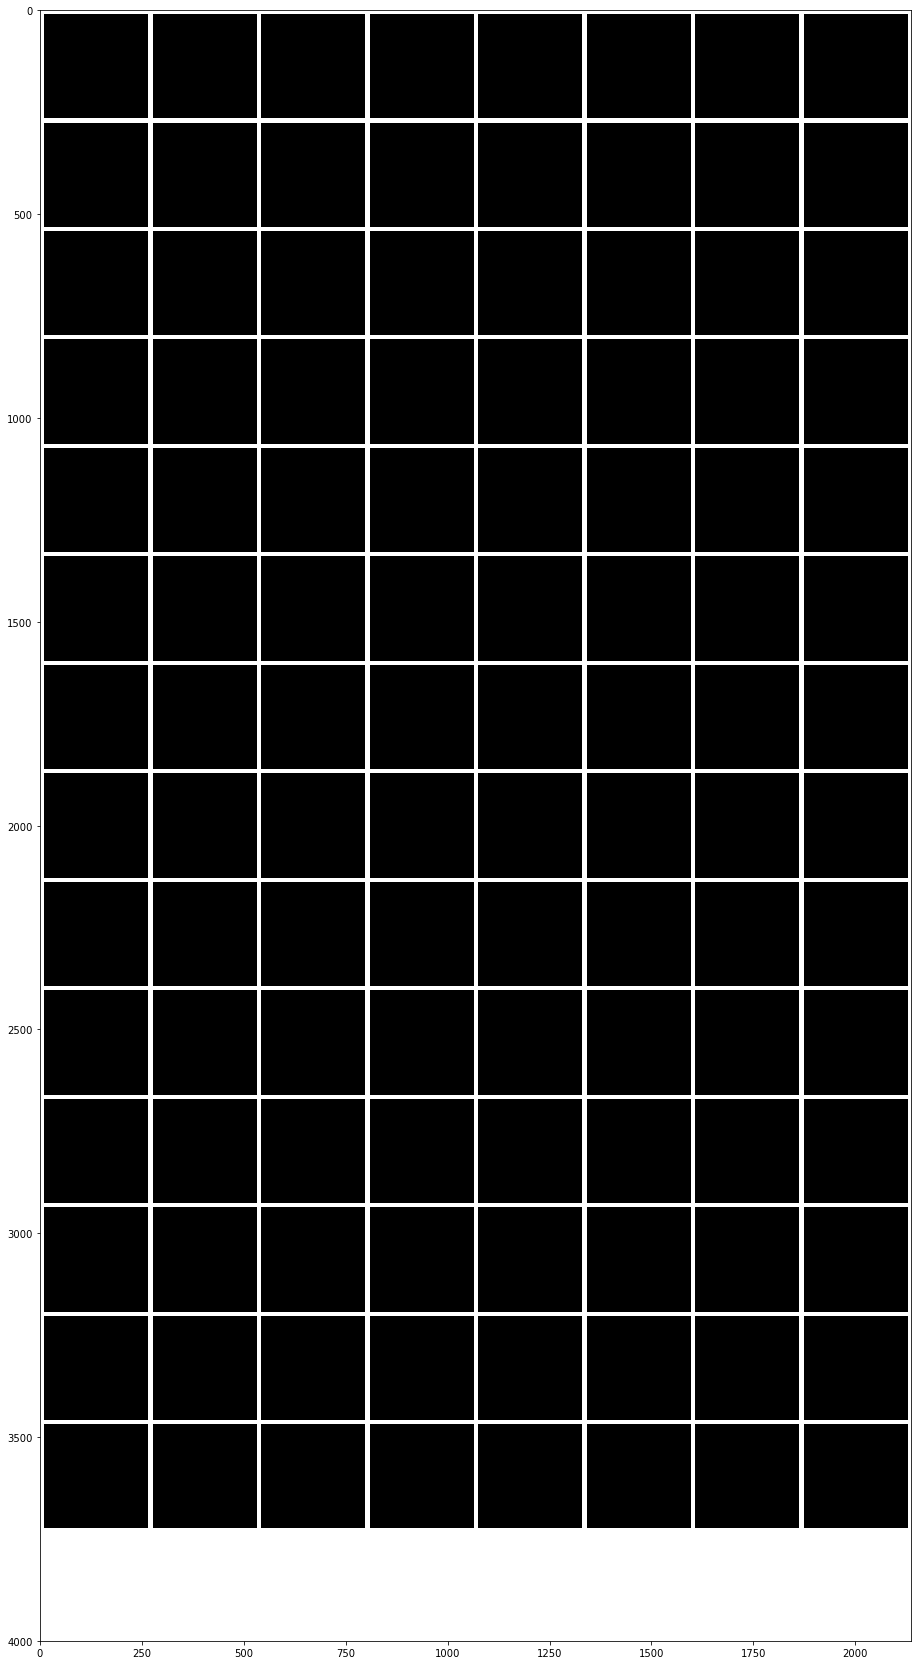

----------------------------------------------------------------------------------------------------
Ground Truth


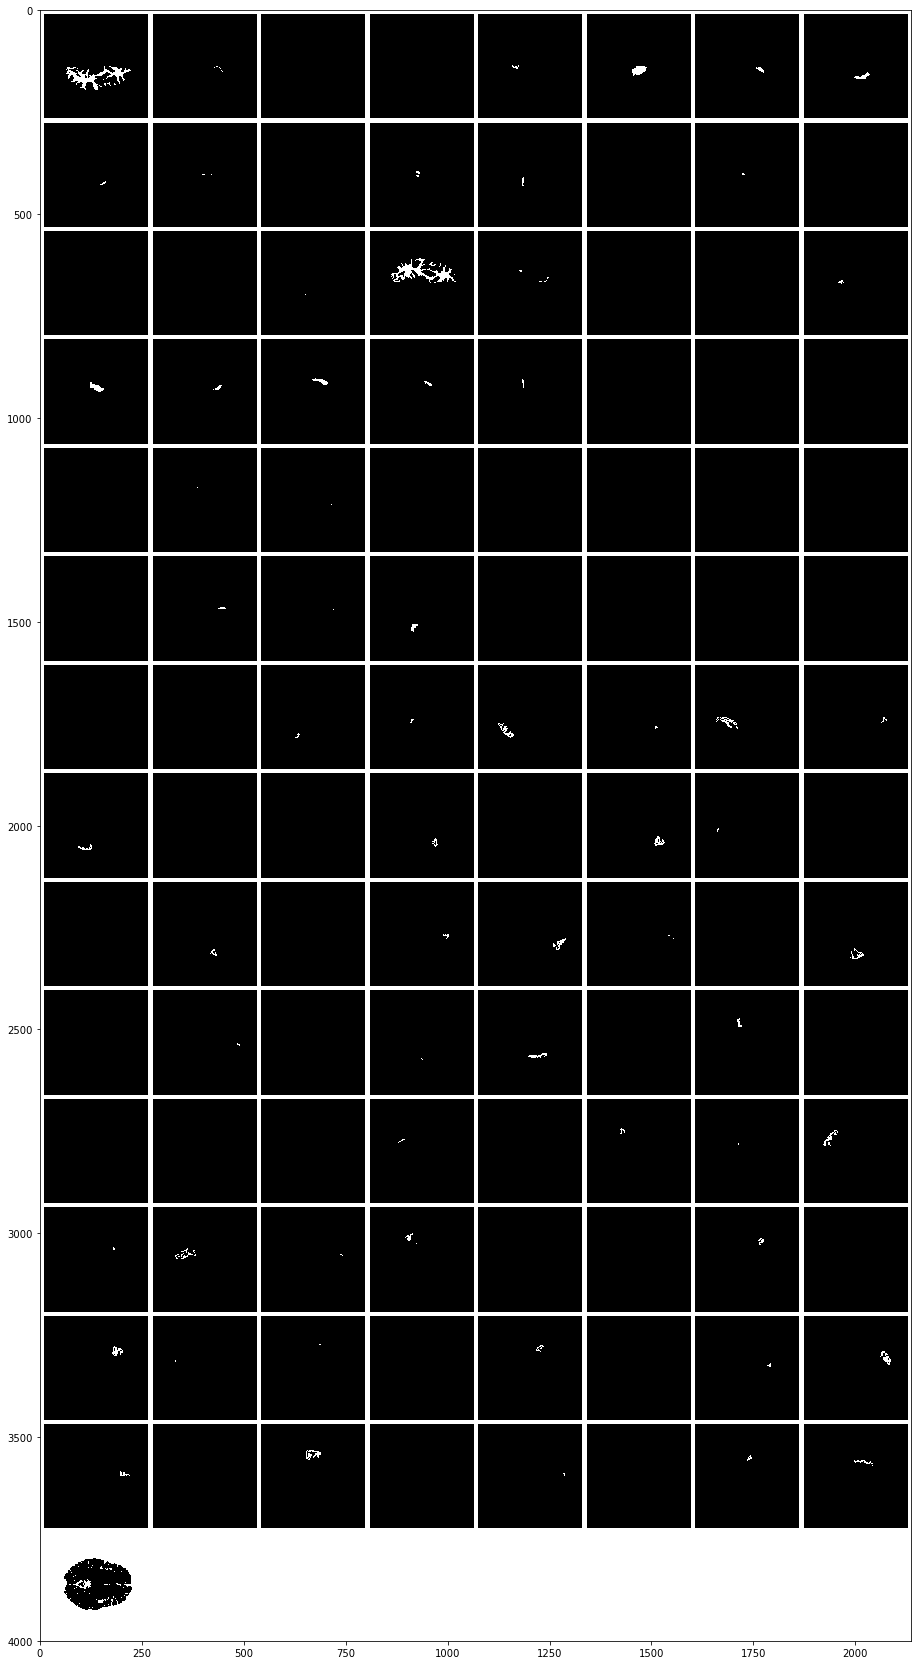

----------------------------------------------------------------------------------------------------
Prediction


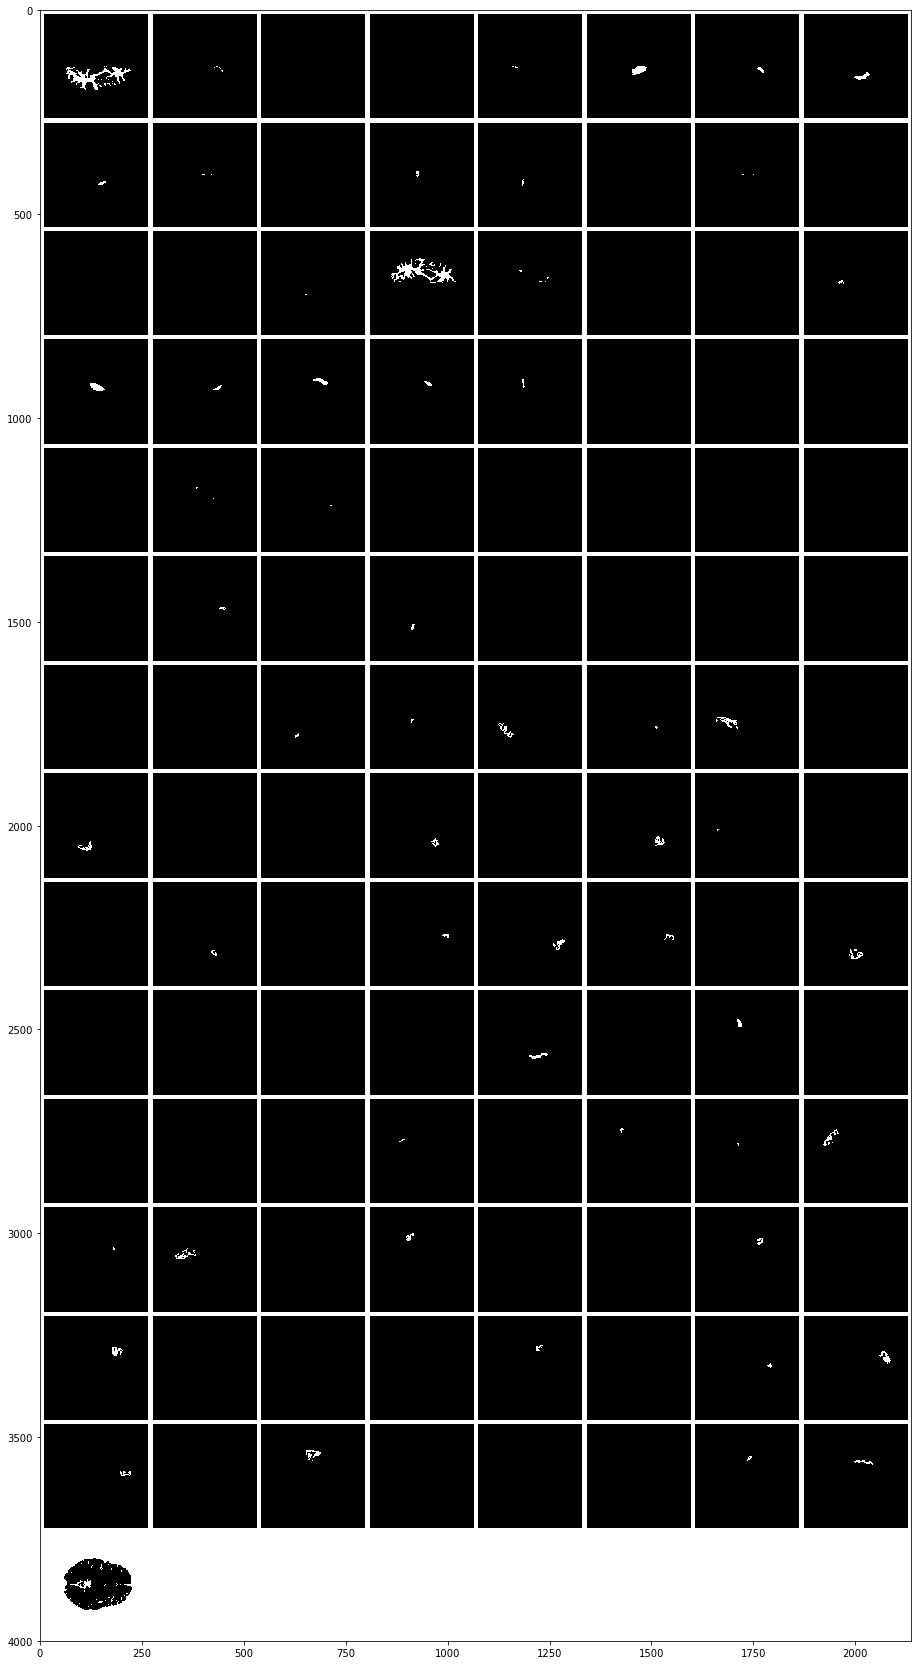

----------------------------------------------------------------------------------------------------
Ground Truth


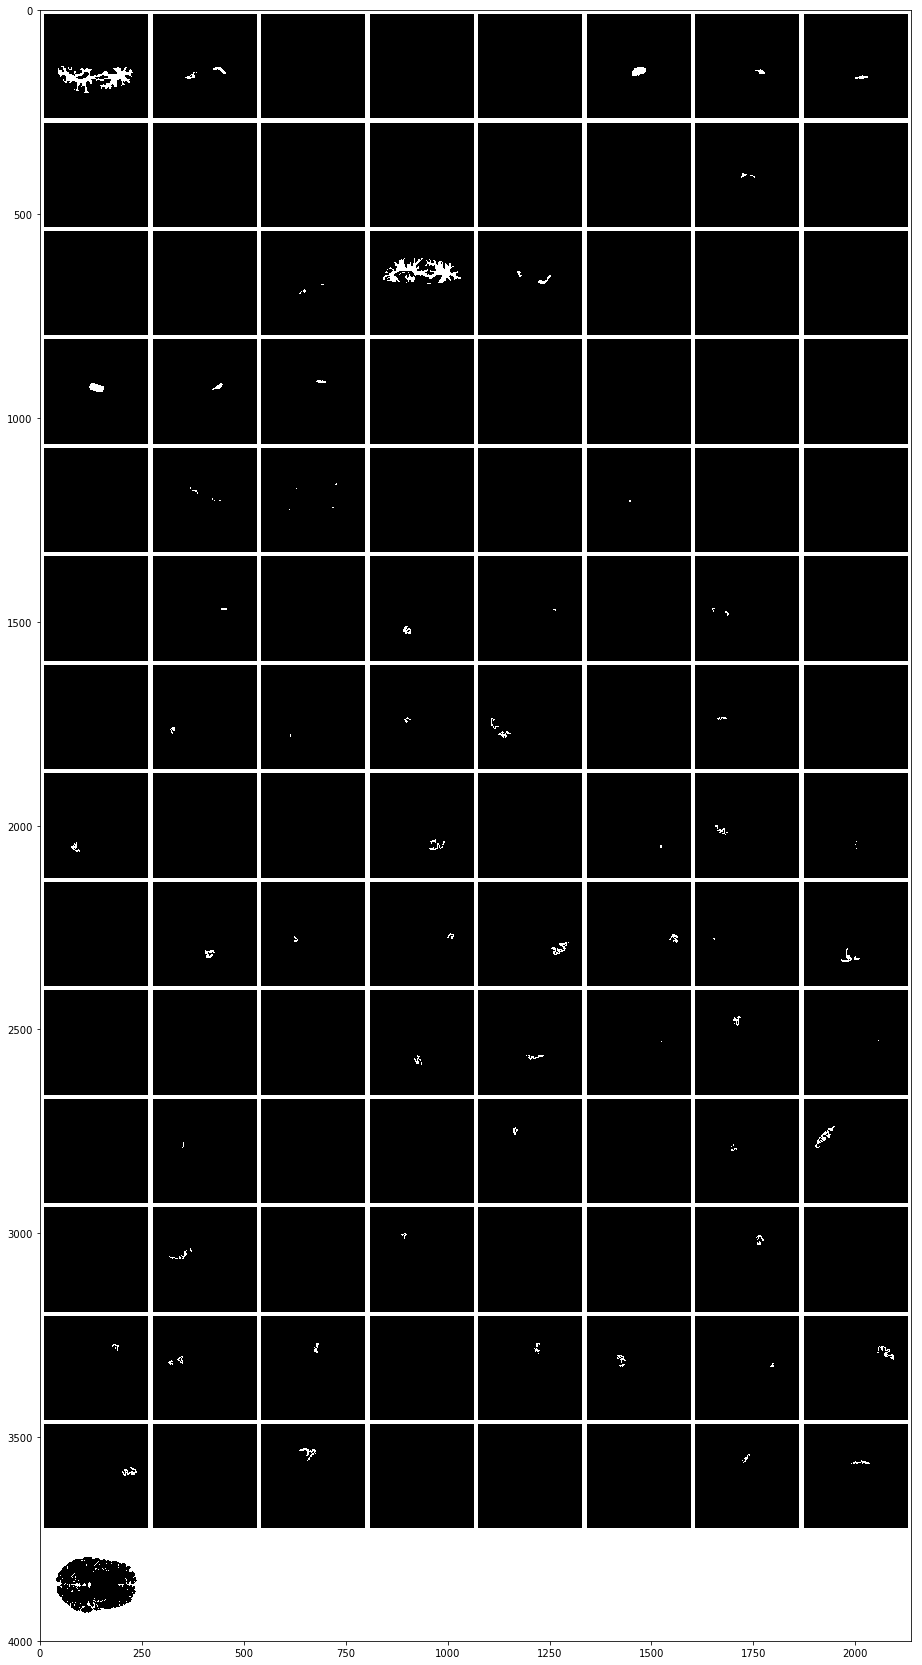

----------------------------------------------------------------------------------------------------
Prediction


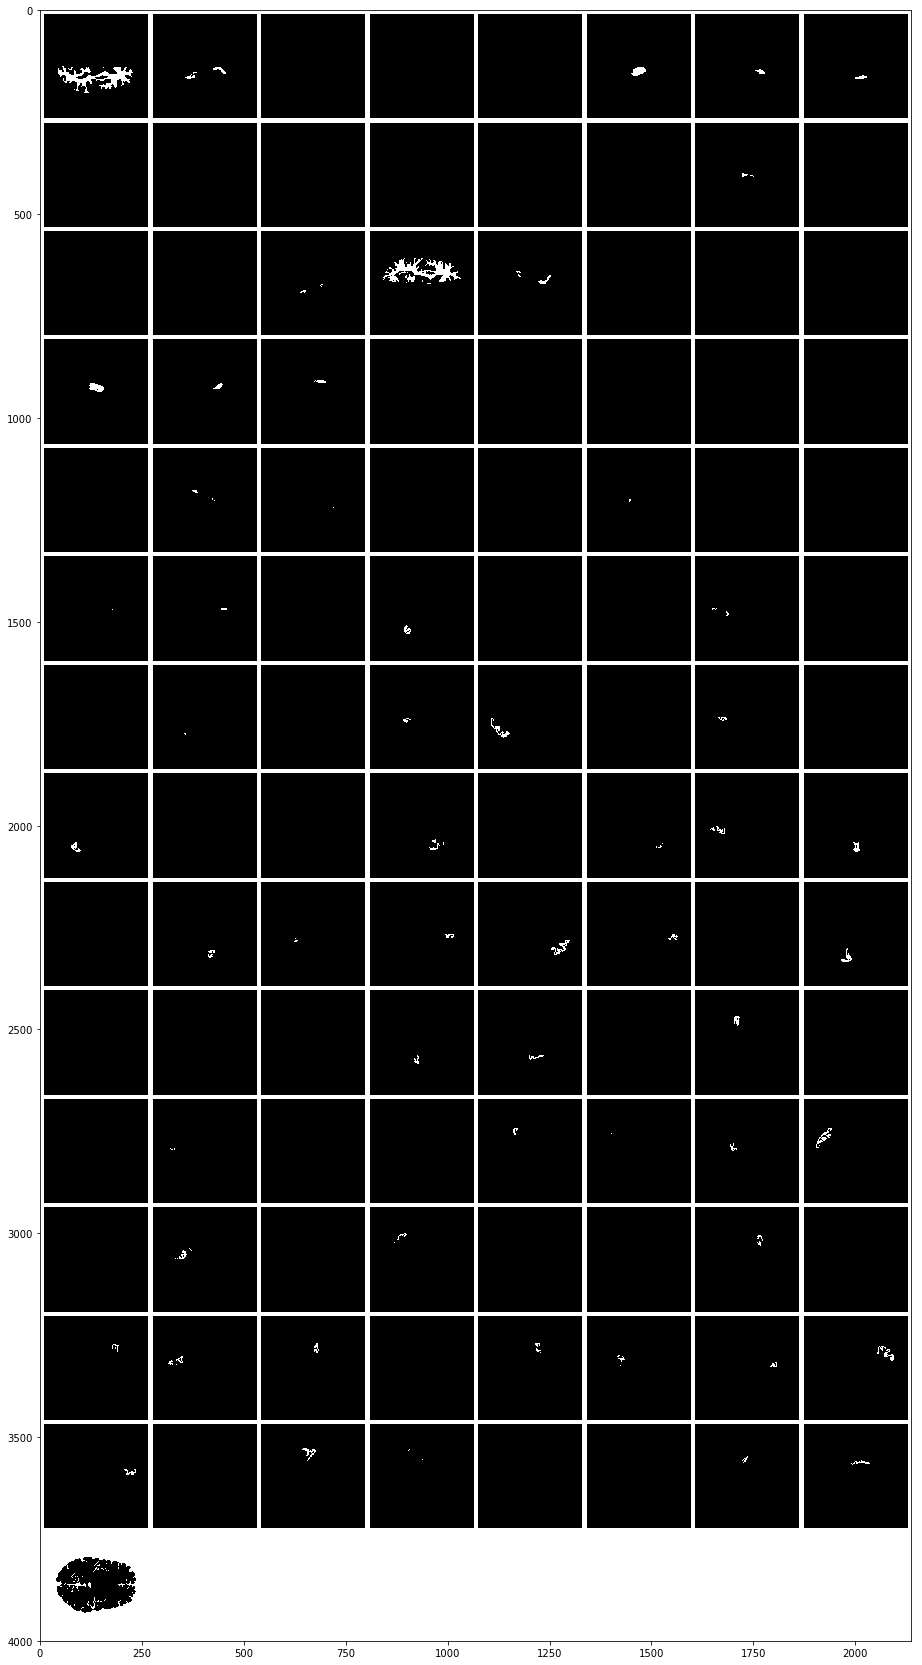

----------------------------------------------------------------------------------------------------
Ground Truth


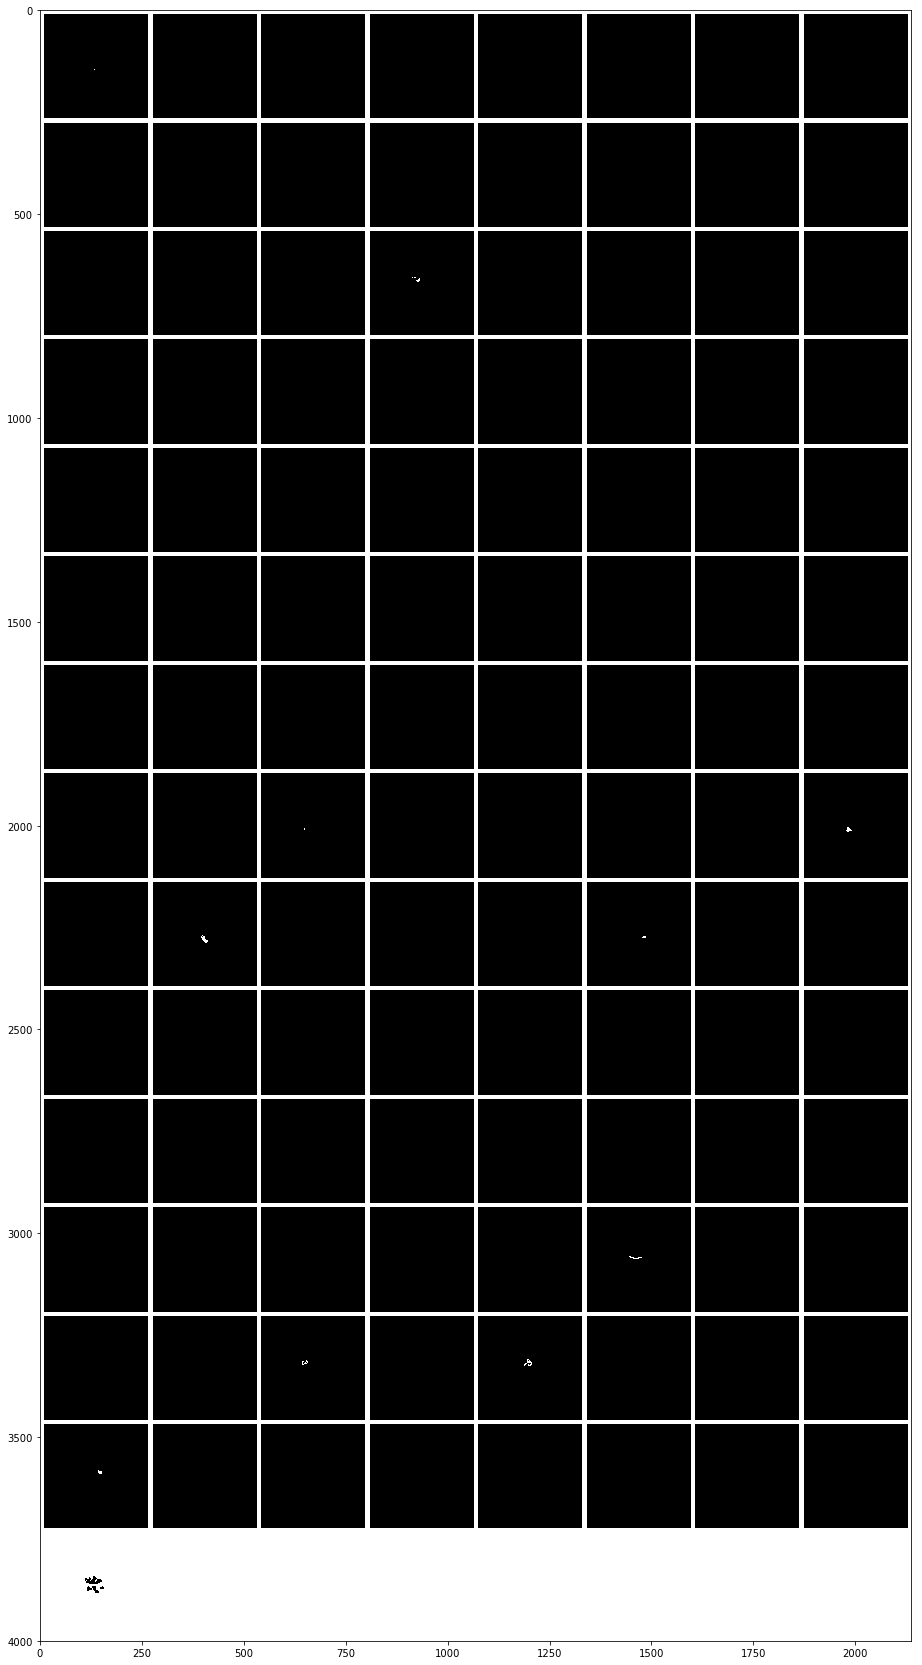

----------------------------------------------------------------------------------------------------
Prediction


In [ ]:
data = next(iter(dataloader["validate"]))
model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = model(x)
for i in range(bs):
    print('-'*100)
    print('Ground Truth')
    abc = data['y'][i,:,:,:]
    bcd = abc.resize(num_seg,1,256,256)
    show(make_grid(bcd,padding=10,pad_value=1)) 
    print('-'*100)
    print('Prediction')
    show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))